# Spaceship Titanic project on Kaggle
----------------------
## Predicting wich passengers got transported into another dimension
**Made by: Thiago Macedo**

### Describing the columns
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Importing necessary libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, normalize
import re
from xgboost import XGBClassifier

sns.set_style('darkgrid')

### Reading Data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
display(df_train.head())
print(df_train.shape)
display(df_test.head())
print(df_test.shape)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


(4277, 13)


In [3]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

### Exploring Data

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


**There are:** 
- 1 **boolean** variable
- 6 **float64** variables
- 7 **object** variables

In [5]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0


### Checking null values

In [6]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
df_train.isnull().sum()*100/len(df_train)

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

Most columns have about 2% of null values, so, I can find a way to input the missing values and still making the data relevant.

### Dealing with useless columns and Null values 

In [8]:
len(df_train.PassengerId.unique())

8693

Each passenger ID is unique

In [9]:
df_train['PassengerGroup'] = [value[0:4] for value in df_train.PassengerId.values]
len(df_train.PassengerGroup.unique())

6217

In [10]:
df_train.drop('PassengerGroup', axis=1, inplace=True)
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 6217 different passenger groups, so none of this column won't help my analysis. Also, the Name of the passenger doesn't have any predictive power, so I won't bother to check it. 

#### Dropping useless columns

In [11]:
def useless_column_dropper(df):
    """drops the columns PassengerId and Name from the dataframe"""
    df.drop('PassengerId', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    
useless_column_dropper(df_train)
df_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


**Both columns have been dropped**

In [12]:
# dropping on the test dataset
useless_column_dropper(df_test)

In [13]:
df_train['Deck'] = df_train.Cabin.str[0]
df_test['Deck'] = df_test.Cabin.str[0]
df_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F


In [14]:
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

### Filling null values

In [15]:
def column_nulls_analysis(df):
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            print('\nColumn: '+column)
            if df[column].dtype == 'O':
                print('\nValue Counts:')
                print(df[column].value_counts())
                print('\nValue that will replace the nulls:',df[column].mode().loc[0])
                print('-'*50)
            elif df[column].dtype == 'float64':
                print(f'\nColumn Mean:{df[column].mean()}')
                print(f'Column Median: {df[column].median()}')
                print(f'Column Max: {df[column].max()}')
                print(f'Column Min: {df[column].min()}')
                print('-'*50)
            
print(column_nulls_analysis(df_train))


Column: HomePlanet

Value Counts:
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Value that will replace the nulls: Earth
--------------------------------------------------

Column: CryoSleep

Value Counts:
False    5439
True     3037
Name: CryoSleep, dtype: int64

Value that will replace the nulls: False
--------------------------------------------------

Column: Destination

Value Counts:
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Value that will replace the nulls: TRAPPIST-1e
--------------------------------------------------

Column: Age

Column Mean:28.82793046746535
Column Median: 27.0
Column Max: 79.0
Column Min: 0.0
--------------------------------------------------

Column: VIP

Value Counts:
False    8291
True      199
Name: VIP, dtype: int64

Value that will replace the nulls: False
--------------------------------------------------

Column: RoomService

Column Mean:224.687617481203
Column

For the **Age** column, I will fill the null values with the mean age, and for all the other numerical columns, I will fill the null values with the median (whick is 0 for all of them) because is much more likely that those passengers didn't spend any dolar with the amenities.

In [16]:
def null_value_filler(df):
    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode().loc[0])
    df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode().loc[0])
    df['Deck'] = df['Deck'].fillna(df['Deck'].mode().loc[0])
    df['Destination'] = df['Destination'].fillna(df['Destination'].mode().loc[0])
    df['VIP'] = df['VIP'].fillna(df['VIP'].mode().loc[0])
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['RoomService'] = df['RoomService'].fillna(df['RoomService'].median())
    df['FoodCourt'] = df['FoodCourt'].fillna(df['FoodCourt'].median())
    df['ShoppingMall'] = df['ShoppingMall'].fillna(df['ShoppingMall'].median())
    df['Spa'] = df['Spa'].fillna(df['Spa'].median())
    df['VRDeck'] = df['VRDeck'].fillna(df['VRDeck'].median())
    
null_value_filler(df_train)
null_value_filler(df_test)
print(df_train.isnull().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
dtype: int64


In [17]:
df_train.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F
5,Earth,False,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,F
6,Earth,False,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,F
7,Earth,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,True,G
8,Earth,False,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,F
9,Europa,True,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,B


# Exploratory Data Analysis

### Home Planet

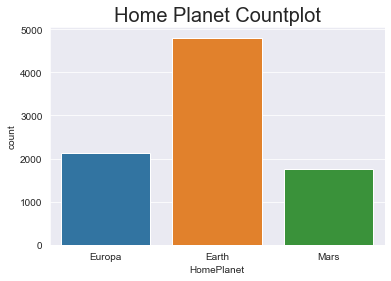

In [31]:
sns.countplot(x='HomePlanet', data=df_train)
plt.title('Home Planet Countplot', size=20)
plt.show()

- Earth is definitely the most common home planet, folowed by Europa (jupyter's satelitte) and then Mars

### CryoSleep